In [3]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt
import numpy as np
import copy
import PIL
import os
from skimage import color
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from nuscenes.utils.data_classes import LidarPointCloud
from pyquaternion import Quaternion
nusc = NuScenes(version='v1.0-mini', dataroot='data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [4]:
import os.path as osp

In [5]:
palette = {}

palette['Bird'] = [165, 42, 42]
palette['Ground Animal'] = [0, 192, 0]
palette['Curb'] = [196, 196, 196]
palette['Fence'] = [190, 153, 153]
palette['Guard Rail'] = [180, 165, 180]
palette['Barrier'] = [90, 120, 150]
palette['Wall'] = [102, 102, 156]
palette['Bile Lane'] = [128, 64, 255]
palette['Crosswalk - Plain'] = [140, 140, 200]
palette['Curb Cut'] = [170, 170, 170]
palette['Parking'] = [250, 170, 160]
palette['Pedestrian Area'] = [96, 96, 96]
palette['Rail Track'] = [230, 150, 140]
palette['Road'] = [128, 64, 128]
palette['Service Lane'] = [110, 110, 110]
palette['Sidewalk'] = [244, 35, 232]
palette['Bridge'] = [150, 100, 100]
palette['Building'] = [70, 70, 70]
palette['Tunnel'] = [150, 120, 90]
palette['Person'] = [220, 20, 60]
palette['Bicyclist'] = [255, 0, 0]
palette['Motorcyclist'] = [255, 0, 100]
palette['Other Rider'] = [255, 0, 200]
palette['Lane Marking - Crosswalk'] = [200, 128, 128]
palette['Lane Marking - General'] = [255, 255, 255]
palette['Mountain'] = [64, 170, 64]
palette['Sand'] = [230, 160, 50]
palette['Sky'] = [70, 130, 180]
palette['Snow'] = [190, 255, 255]
palette['Terrain'] = [152, 251, 152]
palette['Vegetation'] = [107, 142, 35]
palette['Water'] = [0, 170, 30]
palette['Banner'] = [255, 255, 128]
palette['Bench'] = [250, 0, 30]
palette['Bike Rack'] = [100, 140, 180]
palette['Billboard'] = [220, 220, 220]
palette['Catch Basin'] = [220, 128, 128]
palette['CCTV Camera'] = [222, 40, 40]
palette['Fire Hydrant'] = [100, 170, 30]
palette['Junction Box'] = [40, 40, 40]
palette['Mailbox'] = [33, 33, 33]
palette['Manhole'] = [100, 128, 160]
palette['Phone Booth'] = [142, 0, 0]
palette['Pothole'] = [70, 100, 150]
palette['Street Light'] = [210, 170, 100]
palette['Pole'] = [153, 153, 153]
palette['Traffic Sign Frame'] = [128, 128, 128]
palette['Utility Pole'] = [0, 0, 80]
palette['Traffic Light'] = [250, 170, 30]
palette['Traffic Sign (Back)'] = [192, 192, 192]
palette['Traffic Sign (Front)'] = [220, 220, 0]
palette['Trash Can'] = [140, 140, 20]
palette['Bicycle'] = [119, 11, 32]
palette['Boat'] = [150, 0, 255]
palette['Bus'] = [0, 60, 100]
palette['Car'] = [0, 0, 142]
palette['Caravan'] = [0, 0, 90]
palette['Motorcycle'] = [0, 0, 230]
palette['On Rails'] = [0, 80, 100]
palette['Other Vehicle'] = [128, 64, 64]
palette['Trailer'] = [0, 0, 110]
palette['Truck'] = [0, 0, 70]
palette['Wheeled Slow'] = [0, 0, 192]
palette['Car Mount'] = [32, 32, 32]
palette['Ego Vehicle'] = [120, 10, 10]

for k in palette.keys():
    palette[k].append(255)

In [6]:
pixel_to_classidx = {}
class_to_idx = {}
count = 0 
for k in palette: 
    pixel_to_classidx[tuple(palette[k])] = (k, count)
    class_to_idx[k] = count
    count+=1

In [7]:
class_to_idx

{'Bird': 0,
 'Ground Animal': 1,
 'Curb': 2,
 'Fence': 3,
 'Guard Rail': 4,
 'Barrier': 5,
 'Wall': 6,
 'Bile Lane': 7,
 'Crosswalk - Plain': 8,
 'Curb Cut': 9,
 'Parking': 10,
 'Pedestrian Area': 11,
 'Rail Track': 12,
 'Road': 13,
 'Service Lane': 14,
 'Sidewalk': 15,
 'Bridge': 16,
 'Building': 17,
 'Tunnel': 18,
 'Person': 19,
 'Bicyclist': 20,
 'Motorcyclist': 21,
 'Other Rider': 22,
 'Lane Marking - Crosswalk': 23,
 'Lane Marking - General': 24,
 'Mountain': 25,
 'Sand': 26,
 'Sky': 27,
 'Snow': 28,
 'Terrain': 29,
 'Vegetation': 30,
 'Water': 31,
 'Banner': 32,
 'Bench': 33,
 'Bike Rack': 34,
 'Billboard': 35,
 'Catch Basin': 36,
 'CCTV Camera': 37,
 'Fire Hydrant': 38,
 'Junction Box': 39,
 'Mailbox': 40,
 'Manhole': 41,
 'Phone Booth': 42,
 'Pothole': 43,
 'Street Light': 44,
 'Pole': 45,
 'Traffic Sign Frame': 46,
 'Utility Pole': 47,
 'Traffic Light': 48,
 'Traffic Sign (Back)': 49,
 'Traffic Sign (Front)': 50,
 'Trash Can': 51,
 'Bicycle': 52,
 'Boat': 53,
 'Bus': 54,
 'Car

In [8]:
def get_seg(og_seg, plot_images=False, colortype='rgb'):
    '''
    og_seg - image from which intermediate representations will be extracted from (array)
    plot_images - plots images if True, does not plot if False
    colortype - 'binary': plots 1 or 0 (used for occupancy grid), 'grayscale': plots in grayscale for lidar mapping,
                'rgb' or any other string: plots in original palette colors
    returns ret - list of intermediate representations(road, lane, and obstacle in that order so far)
    '''
    if(plot_images):
        plt.figure()
        plt.imshow(og_seg)
    ret = []
    #road segmentation
    inter_seg_road = copy.deepcopy(og_seg)
    inter_seg_road[(og_seg != palette['Road']).any(axis=2)] = [0,0,0,255]  
    ret.append(inter_seg_road)
    
    #lane segmentation
    inter_seg_lane = copy.deepcopy(og_seg)
    crosswalk = (og_seg != palette['Lane Marking - Crosswalk']).any(axis=2)
    general = (og_seg != palette['Lane Marking - General']).any(axis=2) 
    inter_seg_lane[np.logical_and(crosswalk, general)] = [0,0,0,255] 
    ret.append(inter_seg_lane)
    
    #obstacle segmentation (did not include Curb Cut as obstacle but did include Curb)
    inter_seg_obstacle = copy.deepcopy(og_seg)
    building = (og_seg != palette['Building']).any(axis=2)
    curb = (og_seg != palette['Curb']).any(axis=2)
    vegetation = (og_seg != palette['Vegetation']).any(axis=2)
    inter_seg_obstacle[np.logical_and(np.logical_and(building,curb),vegetation)] = [0,0,0,255]
    ret.append(inter_seg_obstacle)
    
    if(colortype == 'grayscale'):
        for i in range(0, len(ret)):
            temp = color.rgb2gray(ret[i])
            ret[i] = temp
            
    elif(colortype == 'binary'):
        for i in range(0, len(ret)):
            temp = color.rgb2gray(ret[i])
            temp[temp > 0] = 1
            ret[i] = temp
    
    
    if(plot_images):
        for i in ret:
            plt.figure()
            if(colortype =='grayscale'):
                plt.imshow(i, cmap='gray')
            else:
                plt.imshow(i)
    return ret
    
    

In [ ]:
source_dir = 'data/sets/nuscenes/samples/CAM_FRONT'
target_dir_road = 'data/sets/nuscenes/samples/ROAD_SEG'
target_dir_lane = 'data/sets/nuscenes/samples/LANE_SEG'
target_dir_obstacle = 'data/sets/nuscenes/samples/OBSTACLE_SEG'
target_dirs = [target_dir_road, target_dir_lane, target_dir_obstacle]
num_files = len(os.listdir(source_dir))
for i, filename in enumerate(os.listdir(source_dir)):
    if i % 10 == 0:
        print('Saving image '+str(i)+' of '+str(num_files))
    if filename.endswith(".jpg"): 
        full_filename = os.path.join(source_dir, filename);
        og_seg = plt.imread(full_filename);
        inter_segs = get_seg(og_seg);
        for j in range(0,len(target_dirs)):
            plt.imsave(os.path.join(target_dirs[j], filename), inter_segs[j]);
        if i == 10: # delete this if you wanna save more than the first 10 images
            break

In [9]:
target_dir = 'data/sets/nuscenes/sweeps/CAM_FRONT'
num_files = len(os.listdir(target_dir))


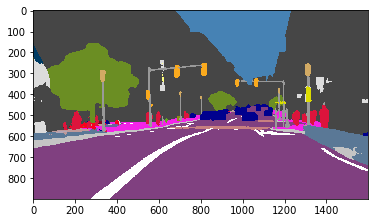

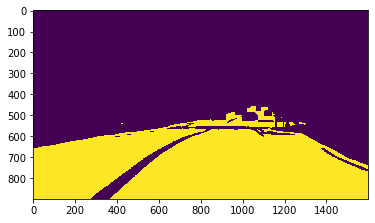

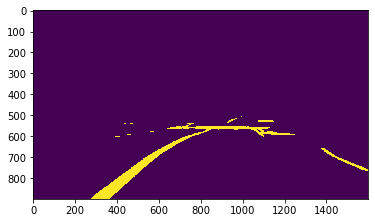

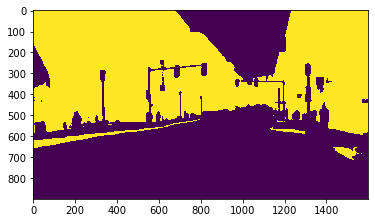

In [8]:
test_og = plt.imread('./data/sets/nuscenes/samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603512404.jpg')
zz = get_seg(test_og, plot_images=True, colortype='binary')

In [9]:
np.count_nonzero(zz[0])

469139

In [10]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

In [11]:
#for a given scene be able to iterate through the scene and retrieve the camera data and lidar data 
#and store it

#once the corresponding camera lidar data retrieved, perform the transformation between lidar to image plane 
#and get the semantic class. Project to lidar points to BEV and start creating the intermediate represnetation 


In [12]:
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
# nusc.list_sample(my_sample['token'])
my_sample['data']
sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
cam_front_data


{'token': 'e3d495d4ac534d54b321f50006683844',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': 'e3d495d4ac534d54b321f50006683844',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402927612460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg',
 'prev': '',
 'next': '68e8e98cf7b0487baa139df808641db7',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

In [13]:
sensor = 'LIDAR_TOP'
lidar_data = nusc.get('sample_data', my_sample['data'][sensor])
lidar_data

{'token': '9d9bf11fb0e144c8b446d54a8a00184f',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': '9d9bf11fb0e144c8b446d54a8a00184f',
 'calibrated_sensor_token': 'a183049901c24361a6b0b11b8013137c',
 'timestamp': 1532402927647951,
 'fileformat': 'pcd',
 'is_key_frame': True,
 'height': 0,
 'width': 0,
 'filename': 'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin',
 'prev': '',
 'next': '0cedf1d2d652468d92d23491136b5d15',
 'sensor_modality': 'lidar',
 'channel': 'LIDAR_TOP'}

In [14]:
cam_front_data['next']

'68e8e98cf7b0487baa139df808641db7'

In [15]:
# Get records from DB
my_scene_token = nusc.field2token('scene', 'name', 'scene-0103')[0]
scene_rec = nusc.get('scene', my_scene_token)
print(scene_rec)
has_more_samples = True 


{'token': 'fcbccedd61424f1b85dcbf8f897f9754', 'log_token': '53cf9c55dd8644bea67b9f009fc1ee38', 'nbr_samples': 40, 'first_sample_token': '3e8750f331d7499e9b5123e9eb70f2e2', 'last_sample_token': '281b92269fd648d4b52d06ac06ca6d65', 'name': 'scene-0103', 'description': 'Many peds right, wait for turning car, long bike rack left, cyclist'}


In [16]:
def get_semantic_class(points, cam_img):
    num_points = points.shape[1]
#     row, column = cam_img.shape[0], cam_img.shape[1]
#     lidar_map = np.zeros(row, column)
#     for i in range(num_points):
#         current_point = np.round(points[:,i][:2])
#         r = int(current_point[0])
#         c = int(current_point[1])
#         if r < cam_img.shape[0] and c < cam_img.shape[1] and\
#            r >= 0 and c >= 0:
#             lidar_map[r, c] = 1 
    
#     segmentations = get_seg(cam_img, colortype='binary')
    class_vec = [-1] * num_points
    for i in range(num_points):
        current_point = np.round(points[:,i][:2])
        r = int(current_point[0])
        c = int(current_point[1])
        if r < cam_img.shape[0] and c < cam_img.shape[1] and\
           r >= 0 and c >= 0:
            object_type, class_id = pixel_to_classidx[(tuple(cam_img[r,c]))]
            class_vec[i] = class_id
    return class_vec

In [17]:
def get_intermediate_rep(BEV_points, semantic_class_per_point):
    num_points = BEV_points.shape[1]
    row, column = cam_data_arr.shape[0], cam_data_arr.shape[1]
    lidar_seg_img = np.zeros((row, column))
    
    for i in range(num_points):
        current_point = np.round(BEV_points[:,i][:2])
        r = int(current_point[0])
        c = int(current_point[1])
        semantic_class = semantic_class_per_point[i]
        if semantic_class == -1: 
            continue
        
        lidar_seg_img[r,c] = semantic_class
    
    #extract the road representations
    road_rep = np.zeros((row, column))
    road_rep[lidar_seg_img == class_to_idx['Road']] = 1 
    
    return road_rep
    


In [18]:
def get_BEV_lidar_points(pointsensor_token):
    
    sd_record = nusc.get('sample_data', pointsensor_token)

    sample_rec = nusc.get('sample', sd_record['sample_token'])
    chan = sd_record['channel']
    ref_chan = 'LIDAR_TOP'
#     ref_sd_token = sd_record['data'][ref_chan]
    ref_sd_token = sample_rec['data']['ref_chan']
    ref_sd_record = nusc.get('sample_data', ref_sd_token)

    # Get aggregated lidar point cloud in lidar frame.
    pc, times = LidarPointCloud.from_file_multisweep(nusc, sd_record, chan, 'LIDAR_TOP', nsweeps=1)

    # By default we render the sample_data top down in the sensor frame.
    # This is slightly inaccurate when rendering the map as the sensor frame may not be perfectly upright.
    # Using use_flat_vehicle_coordinates we can render the map in the ego frame instead.
        # Retrieve transformation matrices for reference point cloud.
    cs_record = nusc.get('calibrated_sensor', ref_sd_record['calibrated_sensor_token'])
    pose_record = nusc.get('ego_pose', ref_sd_record['ego_pose_token'])
    ref_to_ego = transform_matrix(translation=cs_record['translation'],
                                  rotation=Quaternion(cs_record["rotation"]))

    # Compute rotation between 3D vehicle pose and "flat" vehicle pose (parallel to global z plane).
    ego_yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
    rotation_vehicle_flat_from_vehicle = np.dot(
        Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
        Quaternion(pose_record['rotation']).inverse.rotation_matrix)
    vehicle_flat_from_vehicle = np.eye(4)
    vehicle_flat_from_vehicle[:3, :3] = rotation_vehicle_flat_from_vehicle
    viewpoint = np.dot(vehicle_flat_from_vehicle, ref_to_ego)

    # get points that are in BEV
    points = view_points(pc.points[:3, :], viewpoint, normalize=False)
    
#         dists = np.sqrt(np.sum(pc.points[:2, :] ** 2, axis=0))
#         colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
#         point_scale = 0.2 if sensor_modality == 'lidar' else 3.0
#         scatter = ax.scatter(points[0, :], points[1, :], c=colors, s=point_scale)

    return points



In [19]:
def rotate(points, rotation_matrix):
#     import pdb; pdb.set_trace()
    new_points = copy.deepcopy(points)
    new_points[:3, :] = np.dot(rotation_matrix, new_points[:3, :])
    return new_points 
    
def translate(points, x):
#     import pdb; pdb.set_trace()
    new_points = copy.deepcopy(points)
    for i in range(3):
        new_points[i, :] = new_points[i, :] + x[i]
    return new_points


In [20]:
def tranform_image_to_point_cloud(points, pointsensor_token, camera_token):
    '''
        maps points in image frame to sensor frame 
    '''
    cam = nusc.get('sample_data', camera_token)
    pointsensor = nusc.get('sample_data', pointsensor_token)
    
    init_points = copy.deepcopy(points)
    
    #transform out of camera to ego vehicle frame
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    p1 = rotate(points, Quaternion(cs_record['rotation']).rotation_matrix)
    p2 = translate(p1, np.array(cs_record['translation']))
    
    #transform from ego vehicle frame to global frame
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    p3 = rotate(p2, Quaternion(poserecord['rotation']).rotation_matrix)
    p4 = translate(p3, np.array(poserecord['translation']))
    
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    p5 = translate(p4, -np.array(poserecord['translation']))
    p6 = rotate(p5, Quaternion(poserecord['rotation']).rotation_matrix.T)

    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    p7 = translate(p6, -np.array(cs_record['translation']))
    p8 = rotate(p7, Quaternion(cs_record['rotation']).rotation_matrix.T)
    
    assert(init_points[:3,:] != p8[:3,:]).all()
    
    return p8

In [22]:
def transform_point_cloud_to_image(pointsensor_token, camera_token, return_initial=False):
    '''
        maps points from sensor frame to image plane
    '''
    
    cam = nusc.get('sample_data', camera_token)
    pointsensor = nusc.get('sample_data', pointsensor_token)
    sample_rec = nusc.get('sample', )
#     pcl_path = osp.join(nusc.dataroot, pointsensor['filename'])
#     pc = LidarPointCloud.from_file(pcl_path)
    
#     pc, times = 



In [28]:
def get_lidar_data_pc(lidar_data_token, nsweeps=1):
    sd_record = nusc.get('sample_data', lidar_data_token)
    sample_rec = nusc.get('sample', sd_record['sample_token'])
    chan = sd_record['channel']
    ref_channel = 'LIDAR_TOP'
    ref_sd_token = sample_rec['data'][ref_channel]
    ref_sd_record = nusc.get('sample_data', ref_sd_token)
    pc, times = LidarPointCloud.from_file_multisweep(nusc, sample_rec, chan, ref_channel, nsweeps=nsweeps)
    return pc, times


In [36]:
def project_points_to_image(pc, lidar_data, cam):
    cs_record = nusc.get('calibrated_sensor', lidar_data['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))

    # Second step: transform to the global frame.
    poserecord = nusc.get('ego_pose', lidar_data['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))
    
    global_frame_pc = copy.deepcopy(pc)  

    # Third step: transform into the ego vehicle frame for the timestamp of the image.
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

    # Fourth step: transform into the camera.
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)
    
    return pc, global_frame_pc
    

In [43]:
def mask_img_points(points, depths, cam_data_arr, min_dist=1.0):
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < cam_data_arr.shape[1] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < cam_data_arr.shape[0] - 1)
    return mask

In [49]:
def project_points_to_BEV(pc, lidar_data):
    cs_record = nusc.get('calibrated_sensor', lidar_data['calibrated_sensor_token'])
    pose_record = nusc.get('ego_pose', lidar_data['ego_pose_token'])
    ref_to_ego = transform_matrix(translation=cs_record['translation'],
                                  rotation=Quaternion(cs_record["rotation"]))

    # Compute rotation between 3D vehicle pose and "flat" vehicle pose (parallel to global z plane).
    ego_yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
    rotation_vehicle_flat_from_vehicle = np.dot(
        Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
        Quaternion(pose_record['rotation']).inverse.rotation_matrix)
    vehicle_flat_from_vehicle = np.eye(4)
    vehicle_flat_from_vehicle[:3, :3] = rotation_vehicle_flat_from_vehicle
    viewpoint = np.dot(vehicle_flat_from_vehicle, ref_to_ego) 
    points = view_points(pc.points[:3, :], viewpoint, normalize=False)
    return points
    

In [50]:
# Get records from DB
my_scene_token = nusc.field2token('scene', 'name', 'scene-0103')[0]
scene_rec = nusc.get('scene', my_scene_token)
current_token = scene_rec['first_sample_token']
has_more = True 
num_samples = 0
while has_more: 
    
    num_samples += 1
    sample_rec = nusc.get('sample', current_token)
    
    #get camera data 
    camera_token = sample_rec['data']['CAM_FRONT']
    cam_data_arr = plt.imread('./data/sets/nuscenes/' + cam_front_data['filename'])
    cam = nusc.get('sample_data', camera_token)
    im = PIL.Image.open(osp.join(nusc.dataroot, cam_front_data['filename']))
    
    #get lidar data
    lidar_data = nusc.get('sample_data', sample_rec['data']['LIDAR_TOP'])
    lidar_data_token = lidar_data['token']
    
    #get the point cloud and the times associated with it 
    pc, times = get_lidar_data_pc(lidar_data_token, nsweeps=1)
    
    #get the all lidar data pc in image frame pc in image and global frames 
    image_pc, global_frame_pc = project_points_to_image(pc, lidar_data, cam)

    # Grab the depths (camera frame z axis points away from the camera).
    depths = image_pc.points[2, :]
    
    #construct the mask that removes all points that are outside of img
    mask = mask_img_points(image_pc.points, depths, cam_data_arr)
    valid_img_points = image_pc.points[:,mask]
    import pdb; pdb.set_trace()
    
    semantic_class_points = get_semantic_class(valid_img_points, cam_data_arr) #for each point vec containing the class it's in
    #only need rows 0 and 1 for BEV, can ignore third row based on
    #how they plot on scatter plot 
    BEV_points = project_points_to_BEV(pc, lidar_data)
    
    #get the corresponding BEV points 
    corresponding_BEV_points = BEV_points[:,mask]
    
    # what to do with the semantic class points and corresponding 
    # BEV points????

    if not sample_rec['next'] == "":
        current_token = sample_rec['next']
    else:
        has_more = False
        

> <ipython-input-50-1ffc13c99257>(36)<module>()
-> semantic_class_points = get_semantic_class(valid_img_points, cam_data_arr) #for each point vec containing the class it's in
(Pdb) n
> <ipython-input-50-1ffc13c99257>(39)<module>()
-> BEV_points = project_points_to_BEV(pc, lidar_data)
(Pdb) len(semantic_class_points)
2545
(Pdb) valid_img_points.shape
(4, 2545)
(Pdb) n
> <ipython-input-50-1ffc13c99257>(41)<module>()
-> corresponding_BEV_points = BEV_points[:,mask]
(Pdb) n
> <ipython-input-50-1ffc13c99257>(87)<module>()
-> if not sample_rec['next'] == "":
(Pdb) corresponding_BEV_points.shape
(3, 2545)
(Pdb) q


BdbQuit: 

In [19]:
'data/sets/nuscenes/samples/LIDAR_TOP/n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151603547590.pcd.bin'

'data/sets/nuscenes/samples/LIDAR_TOP/n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151603547590.pcd.bin'

In [20]:
x = [1, 2, 3]
lidar_points_in_image[:,x]

NameError: name 'lidar_points_in_image' is not defined

In [21]:
for data in cam_data: 
    print(data['filename'])

NameError: name 'cam_data' is not defined

In [22]:
my_scene_token = nusc.field2token('scene', 'name','scene-0061')

In [ ]:
my_scene_token